In [41]:
import os
import torch
from torch import optim, nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

from plot_utils import plot_histogram_balance_of_dataset, plot_loss
import torch.nn.functional as F  # For softmax function
import numpy as np


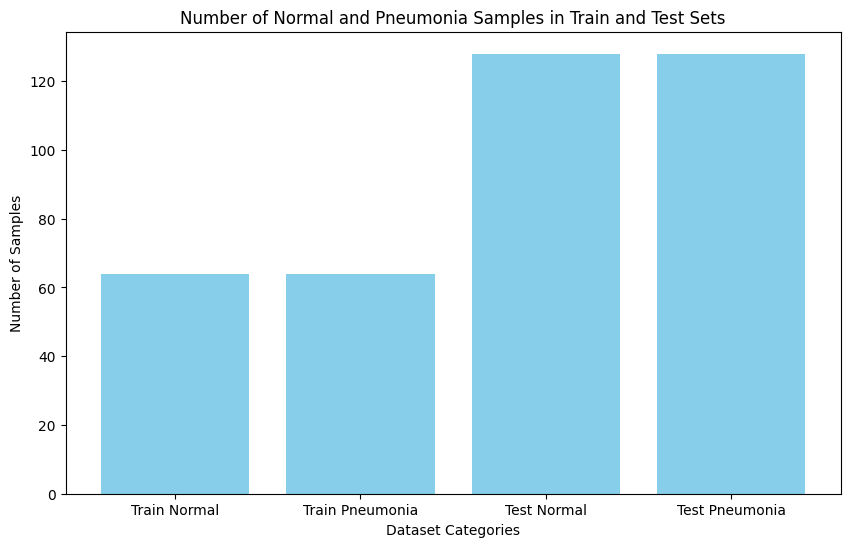

In [42]:
train_val_split_ratio = 1 
batch_size = 8
learning_rate = 0.000001


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the paths to the training and testing directories
train_dir = "train_data_chest_xray_3_3_split"
test_dir = "test_data_chest_xray_3_3_split"
train_normal_dir = os.path.join(train_dir, "NORMAL")
train_pneumonia_dir = os.path.join(train_dir, "PNEUMONIA")
test_normal_dir = os.path.join(test_dir, "NORMAL")
test_pneumonia_dir = os.path.join(test_dir, "PNEUMONIA")
class_names = ["NORMAL", "PNEUMONIA"]
# Count the files in each class
train_normal_count = len(os.listdir(train_normal_dir))
train_pneumonia_count = len(os.listdir(train_pneumonia_dir))
test_normal_count = len(os.listdir(test_normal_dir))
test_pneumonia_count = len(os.listdir(test_pneumonia_dir))

# Combine the counts for plotting
categories = ['Train Normal', 'Train Pneumonia', 'Test Normal', 'Test Pneumonia']
counts = [train_normal_count, train_pneumonia_count, test_normal_count, test_pneumonia_count]
plot_histogram_balance_of_dataset(categories, counts, 'Number of Normal and Pneumonia Samples in Train and Test Sets')

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create custom ImageNet dataset loaders
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Split train_dataset into train and validation subsets
train_size = int(train_val_split_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for each subset
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

#TODO remove
val_loader = test_loader


# Load a pre-trained ResNet-18 model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)


num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move the model to the selected device (CPU or GPU)
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Early Stopping Parameter
patience = 7  
best_val_loss = np.inf  
counter = 0  
best_model_state = None 


# Define ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      
    factor=0.1,      
    patience=2      
)


In [ ]:
# Training loop
# TODO Early Stopping, Reduce lr on plateau
# Split in Train test val
num_epochs = 50
train_losses =[]
val_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for input_tensor, label_tensor in train_loader:
        input_tensor, label_tensor = input_tensor.to(device), label_tensor.to(device)

        output_tensor = model(input_tensor)
        loss = criterion(output_tensor, label_tensor)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input_tensor, label_tensor in val_loader:
            input_tensor, label_tensor = input_tensor.to(device), label_tensor.to(device)
            output_tensor = model(input_tensor)
            loss = criterion(output_tensor, label_tensor)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Learning Rate: {optimizer.param_groups[0]['lr']}")
    
    # Reduce Learning Rate on Plateau
    scheduler.step(val_loss) 
    
    # Check for Early Stopping und store best model
    # Improved mode
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    # No improvement
    else:
        counter += 1 
        if counter >= patience:
            print(f'Early stopping after {epoch+1} Epochs')
            break
                       
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model")


Epoch 1/50, Train Loss: 0.7303060293197632, Validation Loss: 0.6741160284727812, Learning Rate: 1e-06
Epoch 2/50, Train Loss: 0.7077151723206043, Validation Loss: 0.6646148506551981, Learning Rate: 1e-06
Epoch 3/50, Train Loss: 0.66804438829422, Validation Loss: 0.6617908598855138, Learning Rate: 1e-06
Epoch 4/50, Train Loss: 0.6513844057917595, Validation Loss: 0.6524754697456956, Learning Rate: 1e-06
Epoch 5/50, Train Loss: 0.6263670064508915, Validation Loss: 0.6486148769035935, Learning Rate: 1e-06
Epoch 6/50, Train Loss: 0.5788236763328314, Validation Loss: 0.5824099713936448, Learning Rate: 1e-06
Epoch 7/50, Train Loss: 0.4699607901275158, Validation Loss: 0.5024634208530188, Learning Rate: 1e-06
Epoch 8/50, Train Loss: 0.41322641260921955, Validation Loss: 0.4837885661982, Learning Rate: 1e-06
Epoch 9/50, Train Loss: 0.4725781474262476, Validation Loss: 0.508045332506299, Learning Rate: 1e-06


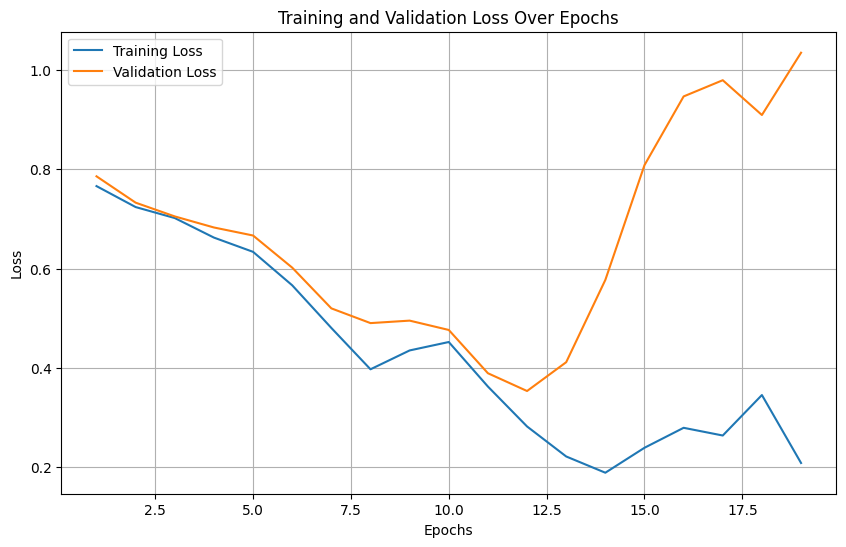

In [39]:
plot_loss(train_losses, val_losses) 

In [40]:
model.eval()  # Set model to evaluation mode
true_labels = []
predicted_labels = []
confidence_values = []
test_correct_preds = 0
test_total_preds = 0

# Assuming you have a test_loader for the test set
with torch.no_grad():  # No need to compute gradients during evaluation
    for input_tensor, label_tensor in test_loader:
        input_tensor, label_tensor = input_tensor.to(device), label_tensor.to(device)

        # Forward pass: get model outputs (logits)
        output_tensor = model(input_tensor)

        # Apply softmax to get probabilities (confidence scores)
        probabilities = F.softmax(output_tensor, dim=1)

        # Get the predicted class (class with the highest probability)
        value_tensor, predicted_tensor = torch.max(probabilities, 1)

        is_sample_correct_predicted = (predicted_tensor == label_tensor)
        for label, predicted_label, value in zip(label_tensor, predicted_tensor, value_tensor):
            true_labels.append(label.item())
            predicted_labels.append(predicted_label.item())
            confidence_values.append(value.item())
            if predicted_label == label:
                test_correct_preds += 1
            
            test_total_preds += 1

test_acc = test_correct_preds / test_total_preds
print(f"Test Accuracy: {test_acc:.4f}")
print(true_labels)
print(predicted_labels)
print(confidence_values)

Test Accuracy: 0.6602
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1